In [1]:
import pandas as pd

# Load files
train_df = pd.read_csv("/content/train_data.csv")
meta_df = pd.read_csv("/content/systems_new.csv")

# Merge on system_id
train_merged = pd.merge(train_df, meta_df, on="system_id", how="left")

# Check result
print(train_merged.head())


   system_id            timestamp  generation_W     load_W connection_type  \
0         17  2023-08-14 01:50:00           0.0  525.66667      COMMERCIAL   
1         17  2023-08-14 02:00:00           0.0  518.90000      COMMERCIAL   
2         17  2023-08-14 02:10:00           0.0  528.50001      COMMERCIAL   
3         17  2023-08-14 02:20:00           0.0  517.99999      COMMERCIAL   
4         17  2023-08-14 02:30:00           0.0  520.90001      COMMERCIAL   

  location  panels_capacity  load_capacity  
0   MARDAN            5.005            5.5  
1   MARDAN            5.005            5.5  
2   MARDAN            5.005            5.5  
3   MARDAN            5.005            5.5  
4   MARDAN            5.005            5.5  


In [2]:
train_merged.tail()

,system_id,timestamp,generation_W,load_W,connection_type,location,panels_capacity,load_capacity
251688,42,2023-08-22 18:50:00,86.33333,10619.00016,RESIDENTIAL,LAHORE,23.98,20.0
251689,42,2023-08-22 19:00:00,0.00000,9932.20005,RESIDENTIAL,LAHORE,23.98,20.0
251690,42,2023-08-22 19:10:00,0.00000,9950.93754,RESIDENTIAL,LAHORE,23.98,20.0
251691,42,2023-08-22 19:20:00,0.00000,9834.22218,RESIDENTIAL,LAHORE,23.98,20.0
251692,42,2023-08-22 19:30:00,0.00000,10476.00000,RESIDENTIAL,LAHORE,23.98,20.0


In [3]:
# Normalize PV generation by panels capacity (convert W → kW capacity)
train_merged["generation_norm"] = train_merged["generation_W"] / (train_merged["panels_capacity"] * 1000)

# Normalize load consumption by load capacity (convert W → kW capacity)
train_merged["load_norm"] = train_merged["load_W"] / (train_merged["load_capacity"] * 1000)

# Optional: clip values > 1 (sometimes anomalies give higher than capacity)
train_merged["generation_norm"] = train_merged["generation_norm"].clip(0, 1.2)
train_merged["load_norm"] = train_merged["load_norm"].clip(0, 1.5)

print(train_merged[["system_id", "generation_W", "panels_capacity", "generation_norm"]].tail())


        system_id  generation_W  panels_capacity  generation_norm
251688         42      86.33333            23.98           0.0036
251689         42       0.00000            23.98           0.0000
251690         42       0.00000            23.98           0.0000
251691         42       0.00000            23.98           0.0000
251692         42       0.00000            23.98           0.0000


In [4]:
def clean_train_missing(train_merged):
    """
    Cleans missing values in the merged training dataset:
    - Replaces -1, -2 with NaN
    - Interpolates short gaps (<= 1 hour)
    - Forward fills longer gaps (<= 6 hours)
    - Fills any remaining NaNs with hour-of-day averages
    - Recomputes normalized columns
    """

    # Step 1: Replace placeholders (-1, -2) with NaN
    train_merged[["generation_W", "load_W"]] = train_merged[["generation_W", "load_W"]].replace([-1, -2], pd.NA)

    # Step 2: Ensure timestamp is datetime
    train_merged["timestamp"] = pd.to_datetime(train_merged["timestamp"], errors="coerce")

    # Step 3: Interpolate short gaps (up to 1 hour = 6 steps)
    train_merged["generation_W"] = train_merged["generation_W"].interpolate(method="linear", limit=6)
    train_merged["load_W"] = train_merged["load_W"].interpolate(method="linear", limit=6)

    # Step 4: Forward-fill longer gaps (<= 6h = 36 steps) → using ffill() to avoid warnings
    train_merged["generation_W"] = train_merged["generation_W"].ffill(limit=36)
    train_merged["load_W"] = train_merged["load_W"].ffill(limit=36)

    # Step 5: Fill remaining NaNs with mean of that hour:minute across all systems
    time_key = train_merged["timestamp"].dt.strftime("%H:%M")
    for col in ["generation_W", "load_W"]:
        train_merged[col] = train_merged.groupby(time_key)[col].transform(lambda x: x.fillna(x.mean()))

    # Step 6: Final safety net
    train_merged = train_merged.dropna(subset=["timestamp"])   # drop rows with bad timestamp
    train_merged["generation_W"] = train_merged["generation_W"].fillna(0)
    train_merged["load_W"] = train_merged["load_W"].fillna(train_merged["load_W"].median())

    # Step 7: Recompute normalized columns
    train_merged["generation_norm"] = train_merged["generation_W"] / (train_merged["panels_capacity"] * 1000)
    train_merged["load_norm"] = train_merged["load_W"] / (train_merged["load_capacity"] * 1000)

    return train_merged


In [5]:
#train_merged = pd.read_csv("train_merged.csv")
train_cleaned = clean_train_missing(train_merged)

print(train_cleaned.isna().sum())  # should show 0 missing values


system_id          0
timestamp          0
generation_W       0
load_W             0
connection_type    0
location           0
panels_capacity    0
load_capacity      0
generation_norm    0
load_norm          0
dtype: int64


In [6]:
def detect_and_fix_anomalies(train_cleaned, tolerance=1.2, add_flags=True):
    """
    Detects and fixes anomalies in PV generation and load:
    - Negative values → set to NaN
    - Spikes beyond system capacity (with tolerance) → set to NaN
    - Optionally adds anomaly flags
    """

    # Negative anomalies
    neg_gen_mask = train_cleaned["generation_W"] < 0
    neg_load_mask = train_cleaned["load_W"] < 0

    # Capacity-based anomalies
    gen_limit = train_cleaned["panels_capacity"] * 1000 * tolerance
    load_limit = train_cleaned["load_capacity"] * 1000 * tolerance

    cap_gen_mask = train_cleaned["generation_W"] > gen_limit
    cap_load_mask = train_cleaned["load_W"] > load_limit

    # Create flags (before replacing values)
    if add_flags:
        train_cleaned["gen_anomaly"] = (neg_gen_mask | cap_gen_mask).astype(int)
        train_cleaned["load_anomaly"] = (neg_load_mask | cap_load_mask).astype(int)

    # Replace anomalies with NaN
    train_cleaned.loc[neg_gen_mask | cap_gen_mask, "generation_W"] = pd.NA
    train_cleaned.loc[neg_load_mask | cap_load_mask, "load_W"] = pd.NA

    return train_cleaned


In [7]:
# Apply anomaly detection
train_cleaned = detect_and_fix_anomalies(train_cleaned, tolerance=1.2)

# Re-run missing value cleaning on the anomalies
train_cleaned = clean_train_missing(train_cleaned)

# Check if everything is fixed
print(train_cleaned.isna().sum())


system_id          0
timestamp          0
generation_W       0
load_W             0
connection_type    0
location           0
panels_capacity    0
load_capacity      0
generation_norm    0
load_norm          0
gen_anomaly        0
load_anomaly       0
dtype: int64


In [8]:
import numpy as np

# Extract datetime components
train_cleaned["hour"] = train_cleaned["timestamp"].dt.hour
train_cleaned["dayofweek"] = train_cleaned["timestamp"].dt.dayofweek
train_cleaned["month"] = train_cleaned["timestamp"].dt.month

# Sine/Cosine encoding for periodicity
train_cleaned["hour_sin"] = np.sin(2 * np.pi * train_cleaned["hour"]/24)
train_cleaned["hour_cos"] = np.cos(2 * np.pi * train_cleaned["hour"]/24)

train_cleaned["day_sin"] = np.sin(2 * np.pi * train_cleaned["dayofweek"]/7)
train_cleaned["day_cos"] = np.cos(2 * np.pi * train_cleaned["dayofweek"]/7)

train_cleaned["month_sin"] = np.sin(2 * np.pi * train_cleaned["month"]/12)
train_cleaned["month_cos"] = np.cos(2 * np.pi * train_cleaned["month"]/12)


In [9]:
# Create lag features for last 1, 2, 3 timesteps (10, 20, 30 min ago)
for lag in [1, 2, 3]:
    train_cleaned[f"gen_lag_{lag}"] = train_cleaned.groupby("system_id")["generation_norm"].shift(lag)
    train_cleaned[f"load_lag_{lag}"] = train_cleaned.groupby("system_id")["load_norm"].shift(lag)

# Daily seasonality lag (same time previous day, i.e. 24h = 144 timesteps back since 10-min intervals)
train_cleaned["gen_lag_144"] = train_cleaned.groupby("system_id")["generation_norm"].shift(144)
train_cleaned["load_lag_144"] = train_cleaned.groupby("system_id")["load_norm"].shift(144)


In [10]:
# One-hot encode connection type
train_cleaned = pd.get_dummies(train_cleaned, columns=["connection_type"], drop_first=True)

# Encode location (label encoding, or one-hot if dataset is small)
from sklearn.preprocessing import LabelEncoder
train_cleaned["location_enc"] = LabelEncoder().fit_transform(train_cleaned["location"])

# Keep capacity as numerical
# panels_capacity, load_capacity already exist


In [11]:
train_cleaned

,system_id,timestamp,generation_W,load_W,location,panels_capacity,load_capacity,generation_norm,load_norm,gen_anomaly,...,gen_lag_1,load_lag_1,gen_lag_2,load_lag_2,gen_lag_3,load_lag_3,gen_lag_144,load_lag_144,connection_type_RESIDENTIAL,location_enc
0,17,2023-08-14 01:50:00,0.00000,525.66667,MARDAN,5.005,5.5,0.0000,0.095576,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4
1,17,2023-08-14 02:00:00,0.00000,518.90000,MARDAN,5.005,5.5,0.0000,0.094345,0,...,0.000000,0.095576,NaN,NaN,NaN,NaN,NaN,NaN,False,4
2,17,2023-08-14 02:10:00,0.00000,528.50001,MARDAN,5.005,5.5,0.0000,0.096091,0,...,0.000000,0.094345,0.000000,0.095576,NaN,NaN,NaN,NaN,False,4
3,17,2023-08-14 02:20:00,0.00000,517.99999,MARDAN,5.005,5.5,0.0000,0.094182,0,...,0.000000,0.096091,0.000000,0.094345,0.000000,0.095576,NaN,NaN,False,4
4,17,2023-08-14 02:30:00,0.00000,520.90001,MARDAN,5.005,5.5,0.0000,0.094709,0,...,0.000000,0.094182,0.000000,0.096091,0.000000,0.094345,NaN,NaN,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251688,42,2023-08-22 18:50:00,86.33333,10619.00016,LAHORE,23.980,20.0,0.0036,0.530950,0,...,0.010926,0.543043,0.012302,0.487741,0.018870,0.354238,0.010342,0.532113,True,3
251689,42,2023-08-22 19:00:00,0.00000,9932.20005,LAHORE,23.980,20.0,0.0000,0.496610,0,...,0.003600,0.530950,0.010926,0.543043,0.012302,0.487741,0.004201,0.554590,True,3
251690,42,2023-08-22 19:10:00,0.00000,9950.93754,LAHORE,23.980,20.0,0.0000,0.497547,0,...,0.000000,0.496610,0.003600,0.530950,0.010926,0.543043,0.000000,0.553474,True,3
251691,42,2023-08-22 19:20:00,0.00000,9834.22218,LAHORE,23.980,20.0,0.0000,0.491711,0,...,0.000000,0.497547,0.000000,0.496610,0.003600,0.530950,0.000000,0.534013,True,3


In [12]:
# Drop rows with NaN from lag features
train_ready = train_cleaned.dropna()

# Features (all except target, timestamp, system_id, raw text fields)
feature_cols = [col for col in train_ready.columns
                if col not in ["system_id","timestamp","generation_norm","load_norm",
                               "generation_W","load_W","location"]]

X = train_ready[feature_cols]
y_gen = train_ready["generation_norm"]
y_load = train_ready["load_norm"]


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_gen, y_val_gen = train_test_split(
    X, y_gen, test_size=0.2, shuffle=False # keep time order!
)
_, _, y_train_load, y_val_load = train_test_split(
    X, y_load, test_size=0.2, shuffle=False
)


###ML Models

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train_gen)

y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val_gen, y_pred)
print("RF Generation RMSE:", rmse)

RF Generation RMSE: 0.0011532349456197881


In [19]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

lgb = LGBMRegressor(n_estimators=500, learning_rate=0.05)
lgb.fit(X_train, y_train_gen,
        eval_set=[(X_val, y_val_gen)],
        callbacks=[early_stopping(stopping_rounds=50)])

y_pred = lgb.predict(X_val)
rmse = mean_squared_error(y_val_gen, y_pred)
print("LightGBM Generation RMSE:", rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 200548, number of used features: 21
[LightGBM] [Info] Start training from score 0.137510
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's l2: 0.00106691
LightGBM Generation RMSE: 0.0010669056206047297


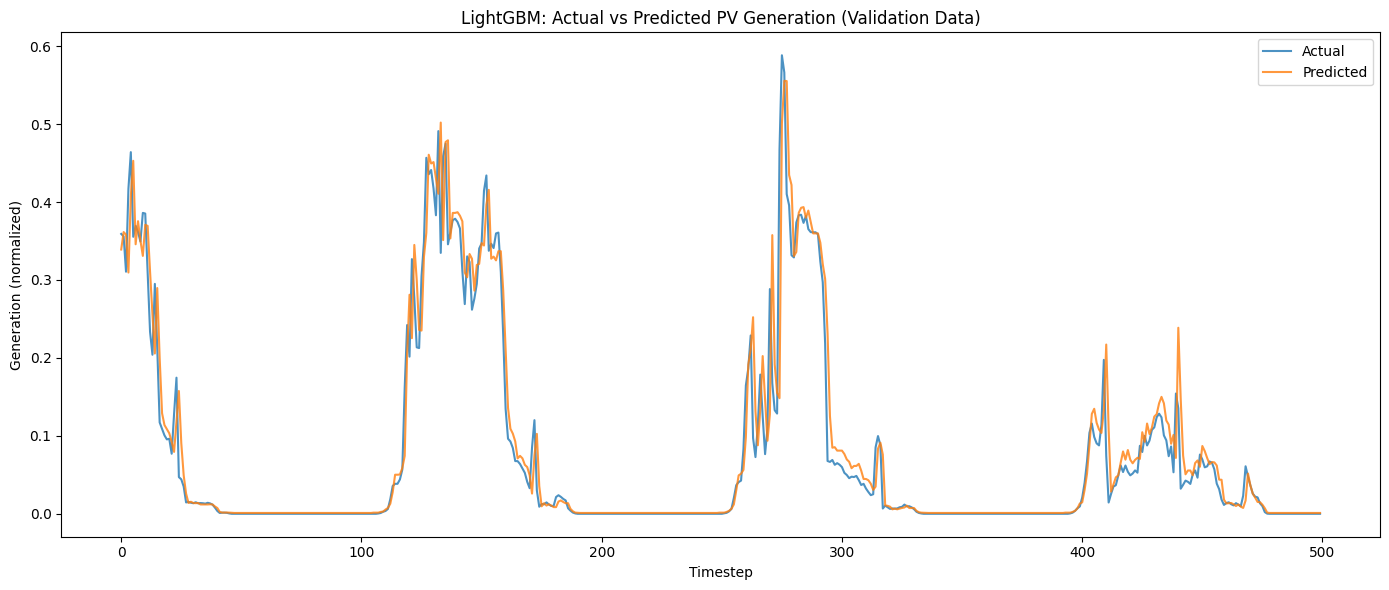

In [24]:
plt.figure(figsize=(14,6))
plt.plot(y_val_gen[:500].values, label="Actual", alpha=0.8)   # true values
plt.plot(y_pred[:500], label="Predicted", alpha=0.8)          # predictions
plt.legend()
plt.title("LightGBM: Actual vs Predicted PV Generation (Validation Data)")
plt.xlabel("Timestep")
plt.ylabel("Generation (normalized)")
plt.tight_layout()
plt.show()


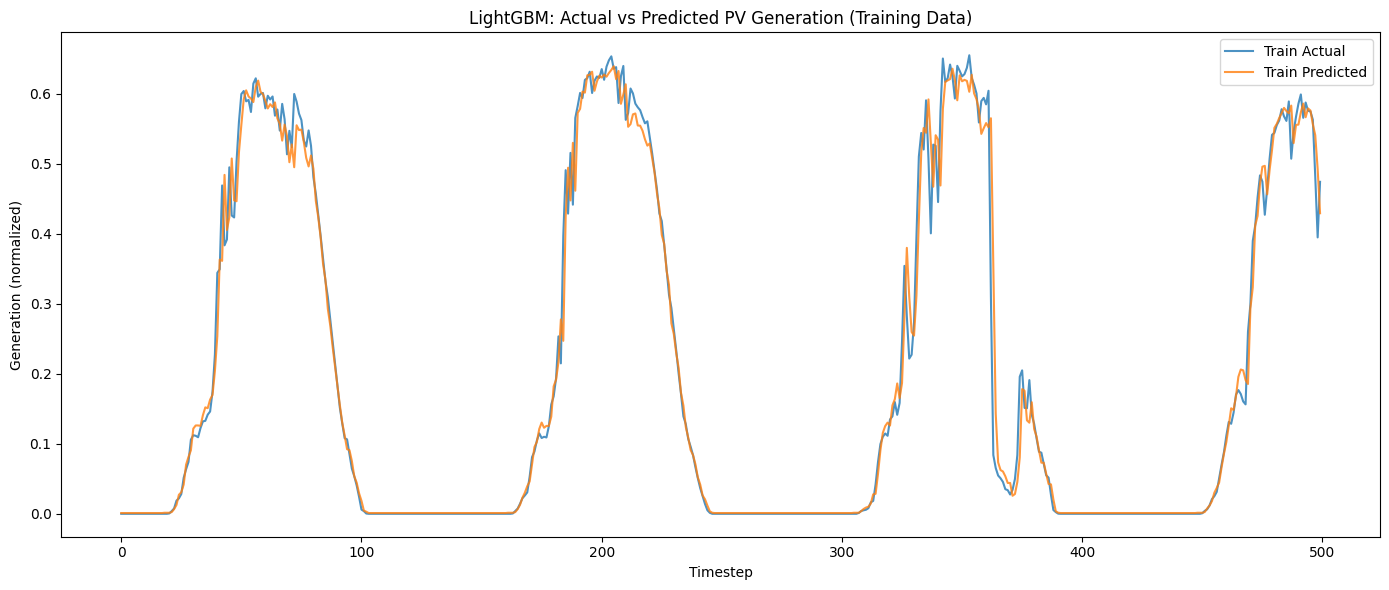

In [25]:
y_train_pred = lgb.predict(X_train)

plt.figure(figsize=(14,6))
plt.plot(y_train_gen[:500].values, label="Train Actual", alpha=0.8)
plt.plot(y_train_pred[:500], label="Train Predicted", alpha=0.8)
plt.legend()
plt.title("LightGBM: Actual vs Predicted PV Generation (Training Data)")
plt.xlabel("Timestep")
plt.ylabel("Generation (normalized)")
plt.tight_layout()
plt.show()


NameError: name 'y_train_pred_gen' is not defined

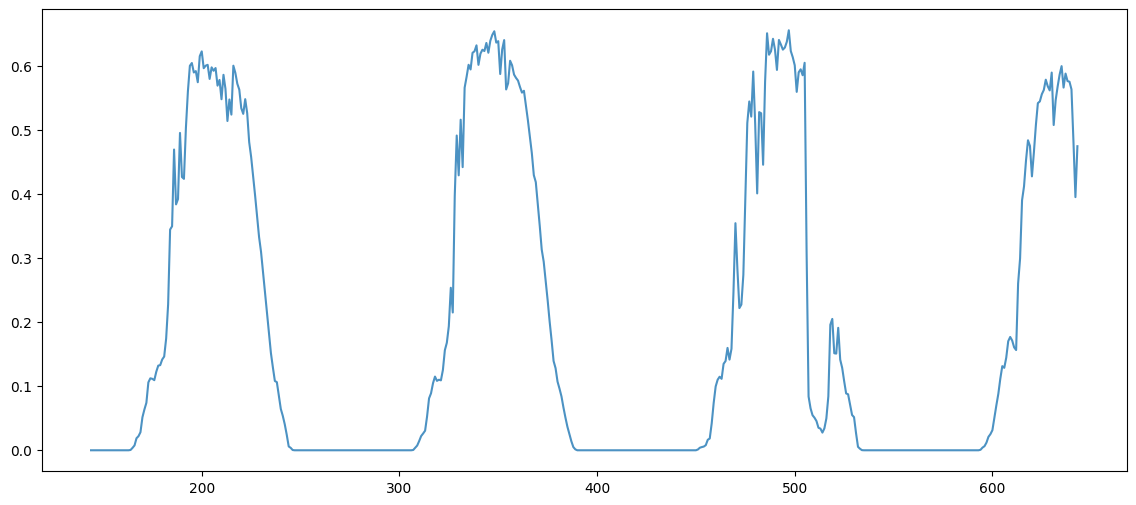

In [23]:
#import matplotlib.pyplot as plt

#plt.figure(figsize=(14,6))
#plt.plot(y_train_gen[:500], label="Actual", alpha=0.8)   # limit to first 500 points for readability
#plt.plot(y_train_pred_gen[:500], label="Predicted", alpha=0.8)
#plt.legend()
#plt.title("LightGBM: Actual vs Predicted PV Generation (Training Data)")
#plt.xlabel("Timestep")
#plt.ylabel("Generation (normalized)")
#plt.tight_layout()
#plt.show()


###DL Model (LSTM)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape into [samples, timesteps, features] for LSTM
# Here: timesteps=1 (use lag features instead of sequence)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train_lstm, X_val_lstm = X_lstm[:len(X_train)], X_lstm[len(X_train):]
y_train_lstm, y_val_lstm = y_train_gen, y_val_gen

model = models.Sequential([
    layers.LSTM(64, activation='tanh', input_shape=(1, X_train_lstm.shape[2])),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_lstm, y_train_lstm,
                    validation_data=(X_val_lstm, y_val_lstm),
                    epochs=20, batch_size=128, verbose=1)

val_pred = model.predict(X_val_lstm)
print("LSTM Generation RMSE:", mean_squared_error(y_val_lstm, val_pred))


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1567/1567 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 2/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 5/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 6/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 9/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 11/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 12/20
1567/1567 ━━━━━━━━━━━━━━━━

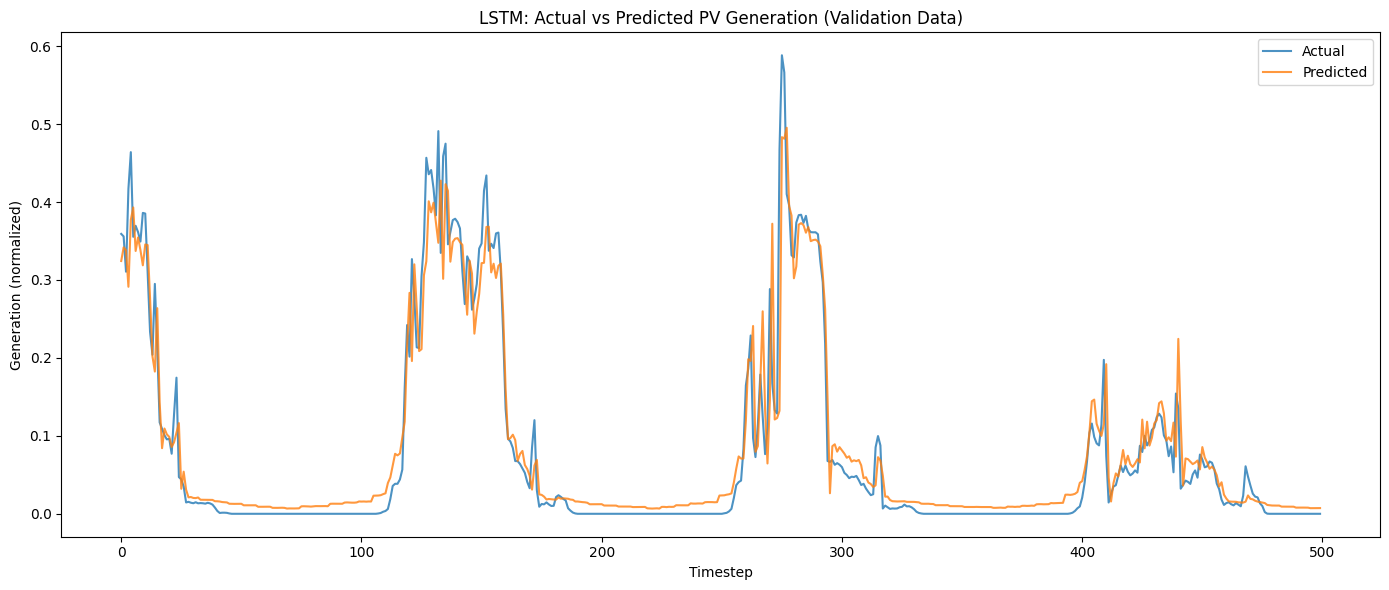

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_val_lstm[:500].values, label="Actual", alpha=0.8)
plt.plot(val_pred[:500], label="Predicted", alpha=0.8)
plt.legend()
plt.title("LSTM: Actual vs Predicted PV Generation (Validation Data)")
plt.xlabel("Timestep")
plt.ylabel("Generation (normalized)")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_train_lstm[:500].values, label="Actual", alpha=0.8)
plt.plot(y_train_pred_lstm[:500], label="Predicted", alpha=0.8)
plt.legend()
plt.title("LSTM: Actual vs Predicted PV Generation (Training Data)")
plt.xlabel("Timestep")
plt.ylabel("Generation (normalized)")
plt.tight_layout()
plt.show()

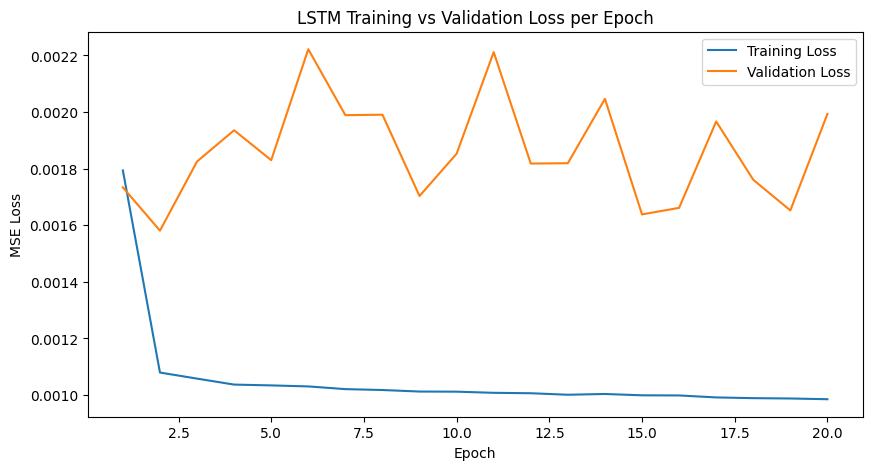

In [27]:
# Plot training and validation loss per epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()
